In [133]:
import tools
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from scipy import integrate
import torch.nn.functional as F

torch.cuda.is_available()

True

In [11]:
x_dict = tools.get_all_surfacelines('rijnland')

Dwarsprofiel 131_042_00019 begint niet op x=0 en wordt geskipped
Dwarsprofiel 131_042_00020 begint niet op x=0 en wordt geskipped
Dwarsprofiel 136_042_00002 begint niet op x=0 en wordt geskipped
Dwarsprofiel 136_042_00003 begint niet op x=0 en wordt geskipped
Dwarsprofiel 136_042_00004 begint niet op x=0 en wordt geskipped
Dwarsprofiel 136_042_00005 begint niet op x=0 en wordt geskipped
Dwarsprofiel 136_042_00006 begint niet op x=0 en wordt geskipped
Dwarsprofiel 136_042_00007 begint niet op x=0 en wordt geskipped
Dwarsprofiel 136_042_00008 begint niet op x=0 en wordt geskipped
Dwarsprofiel 136_042_00011 begint niet op x=0 en wordt geskipped
Dwarsprofiel 136_042_00012 begint niet op x=0 en wordt geskipped
Dwarsprofiel 136_042_00016 begint niet op x=0 en wordt geskipped
Dwarsprofiel 136_042_00017 begint niet op x=0 en wordt geskipped
Dwarsprofiel 136_042_00018 begint niet op x=0 en wordt geskipped
Dwarsprofiel 136_042_00019 begint niet op x=0 en wordt geskipped
Dwarsprofiel 163_042_0000

In [12]:
y_dict = tools.get_all_cpoints('rijnland')

In [167]:
# Choice to truncate the first and last point? They are always clicked, however they give information on the profile of the dyke
# input points
x = [np.array(list(map(lambda x: [x[1], x[2]], p))) for p in [x_dict[k] for k in x_dict.keys()]]

# clicked points
y = [np.array(list(map(lambda x: [x[1], x[2]], p))) for p in [y_dict[k] for k in x_dict.keys()]]

In [168]:
labels = []
for i in range(len(x)):
    c = y[i][np.all(y[i] != -1., 1)]
    idx = [np.argmin(np.sum(np.abs(x[i] - p), 1), axis=0) for p in c]
    l = np.zeros(x[i].shape[0], dtype=int)
    l[idx] = 1
    labels.append(l)

In [153]:
def add_dydx(x):
    d = np.nan_to_num(np.diff(x[:, 1], 1) / np.diff(x[:, 0], 1))
    d[d > 1e3] = 0
    d[d < -1e3] = 0
    d = np.append(d, 0)

    return np.concatenate((x, d[:, None]), 1)
    

x = list(map(add_dydx, x))

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [155]:
def add_integration(x):
    return np.concatenate((x, np.hstack((np.zeros(1), integrate.cumtrapz(x[:, 1], x[:, 0])))[:, None]), 1)

x = list(map(add_integration, x))

In [156]:
def scale_features(x):
    a = np.vstack(x)
    return list(map(lambda x: (x - a.mean(0)) / a.std(0), x))

x = scale_features(x)

In [165]:
n = len(x)
i = int(n * 0.8)
x_train = np.array(x[:i])
x_test = np.array(x[i:])
y_train = np.array(labels[:i])
y_test = np.array(labels[i:])

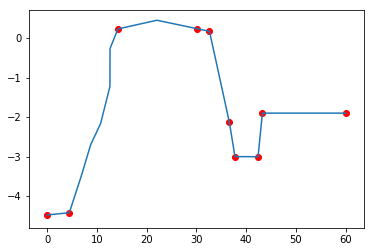

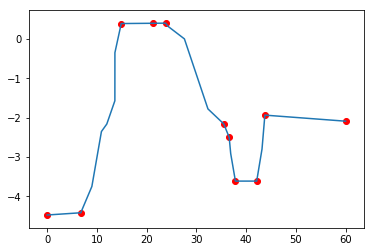

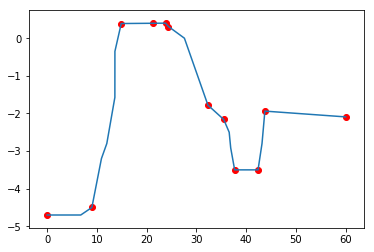

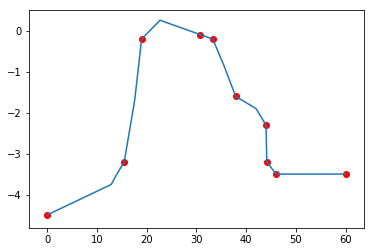

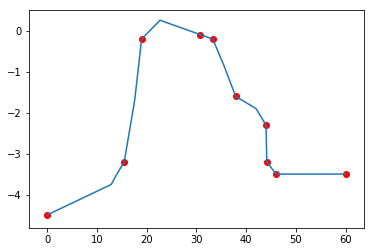

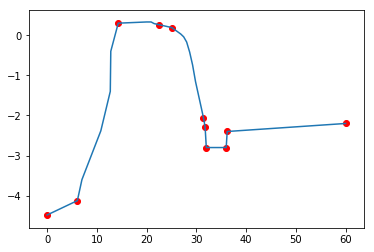

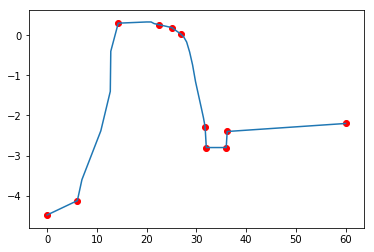

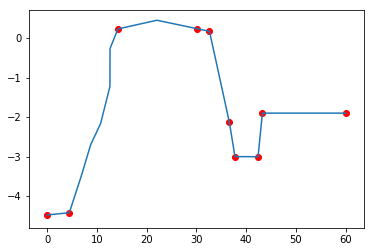

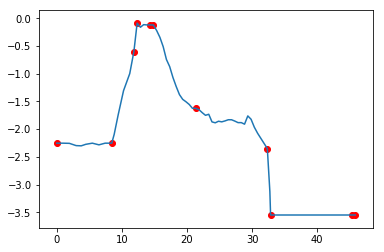

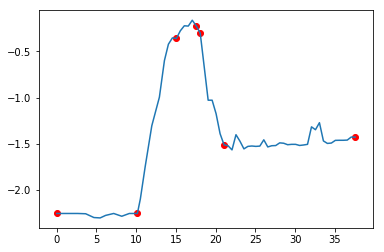

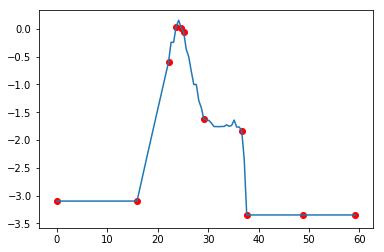

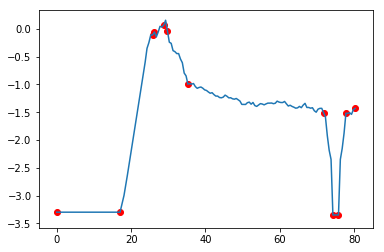

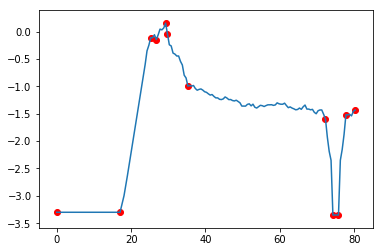

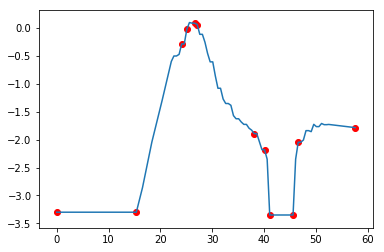

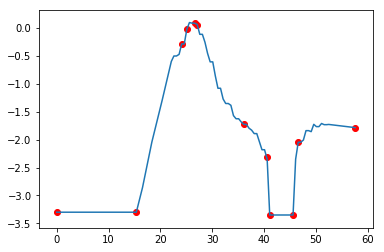

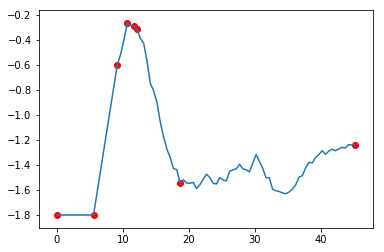

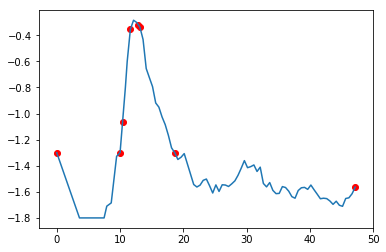

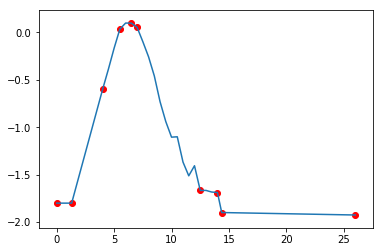

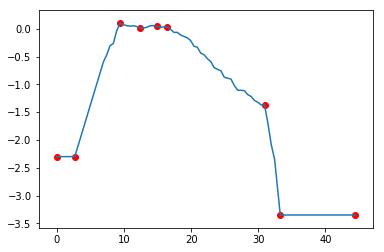

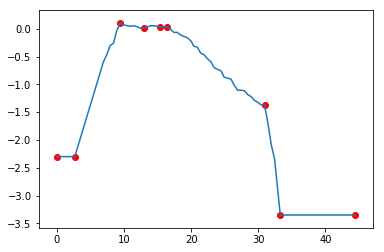

In [170]:
def plot_dyke(x, y, a):
    mask = np.array(y[a], dtype=bool)
    plt.plot(x[a][:, 0], x[a][:, 1])
    plt.scatter(x[a][:, 0][mask], x[a][:, 1][mask], c='r')
    plt.show()

for i in range(20):
    plot_dyke(x, labels, i)

In [161]:
def prepare_batch(x, y):
    n_max = max([a.shape[0] for a in x])
    pad = np.zeros((n_max, len(x), x[0].shape[1]))
    
    lengths = []
    for i in range(len(x)):
        lengths.append(x[i].shape[0])
        # shape = (n-dtc, n-batch, n-features)
        pad[:x[i].shape[0], i:i + 1, :] = x[i][:, None, :]
        
    # mini-batch needs to be in decreasing order
    lengths = np.array(lengths)
    idx = np.argsort(lengths)[::-1]

    return pad[:, idx, :], lengths[idx], np.array(y)[idx]

pad, lengths, _ = prepare_batch(x[:10], labels[:10])
lengths

array([77, 65, 25, 25, 21, 21, 18, 18, 16, 16])

In [171]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=1, bidirectional=1)
        
        self.model = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x, lengths):       
        # pack_padded_sequence so that padded items in the sequence won't be shown the rnn
        x = torch.nn.utils.rnn.pack_padded_sequence(x, lengths)
        x, hidden = self.rnn(x)
        x, _ = torch.nn.utils.rnn.pad_packed_sequence(x)
        
#         s = x.shape
#         x = x.view(s[0], s[1], 2, s[2] // 2)
#         forward_x = x[:, :, 0, :]
#         backward_x = x[:, :, 1, :]
#         print(forward_x.shape)
#         print(torch.cat((forward_x, backward_x), dim=-1).shape)
                
        x = self.model(x)
                
        if self.training:
            return x
        else:
            return F.sigmoid(x)


m = RNN(4, 10, 1)
m(torch.tensor(pad).float(), torch.tensor(lengths))[:, 0]

tensor([[-0.1536],
        [-0.1598],
        [-0.1641],
        [-0.1668],
        [-0.1678],
        [-0.1682],
        [-0.1686],
        [-0.1689],
        [-0.1693],
        [-0.1694],
        [-0.1687],
        [-0.1659],
        [-0.1622],
        [-0.1587],
        [-0.1572],
        [-0.1551],
        [-0.1568],
        [-0.1579],
        [-0.1597],
        [-0.1611],
        [-0.1623],
        [-0.1636],
        [-0.1651],
        [-0.1670],
        [-0.1692],
        [-0.1705],
        [-0.1724],
        [-0.1737],
        [-0.1748],
        [-0.1757],
        [-0.1761],
        [-0.1765],
        [-0.1769],
        [-0.1771],
        [-0.1773],
        [-0.1778],
        [-0.1784],
        [-0.1785],
        [-0.1792],
        [-0.1794],
        [-0.1793],
        [-0.1794],
        [-0.1794],
        [-0.1795],
        [-0.1796],
        [-0.1799],
        [-0.1801],
        [-0.1798],
        [-0.1793],
        [-0.1776],
        [-0.1768],
        [-0.1761],
        [-0.

In [172]:
m = RNN(4, 20, 1).cuda()

In [177]:
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([4.55]).cuda()) 
optim = torch.optim.Adam(m.parameters(), lr=0.001)

epochs = 500
batch_size = 50
print_iter = 10

m.train(True)
def get_prediction(x, y):
    pad, lengths, y = prepare_batch(x, y)
    x = torch.tensor(pad).float()
#     y = torch.tensor(y, dtype=torch.long)
    if next(m.parameters()).is_cuda:
        x = x.cuda()
        lengths = torch.tensor(lengths).long().cuda()
#         y = y.cuda()
        
    return m(x, lengths), y

def test_eval():
    batch_pred, batch_y = get_prediction(x_test, y_test)
    batch_pred = batch_pred.cpu().data.numpy().argmax(1)
    batch_y = batch_y.cpu().data.numpy()
    return batch_pred, batch_y

idx = np.arange(len(x_train))    

for epoch in range(epochs):

    np.random.shuffle(idx)
    x_train = x_train[idx]
    y_train = y_train[idx]
        
    current_batch = 0
    avg_loss = 0
    for iteration in range(y_train.shape[0] // batch_size):
        batch_x = x_train[current_batch: current_batch + batch_size]
        batch_y = y_train[current_batch: current_batch + batch_size]
        current_batch += batch_size
                        
        
        if len(batch_x) > 0:
            batch_pred, batch_y = get_prediction(batch_x, batch_y)
            optim.zero_grad()
            
            loss = 0
            for i in range(batch_y.shape[0]):
                loss += criterion(batch_pred[:batch_y[i].shape[0], 0, 0], torch.tensor(batch_y[i]).float().cuda())
            
            avg_loss += loss.data
            loss.backward()
            optim.step()
        
        
    print(avg_loss)
            
#             if tboard:
#                 tb.add_scalar('loss', loss.item())
            
#             if iteration % print_iter == 0:
#                 with torch.no_grad():
#                     m.train(False)
#                     f1 = f1_score(batch_y.cpu().data.numpy(), batch_pred.cpu().data.numpy().argmax(1), average='weighted')
#                     if tboard:
#                         tb.add_scalar('f1_train', f1.item())

#                     batch_pred, batch_y = test_eval()
#                     f1 = f1_score(batch_y, batch_pred, average='weighted')
#                     precision = precision_score(batch_y, batch_pred, average='weighted')
#                     if tboard:
#                         tb.add_scalar('f1', f1.item())
#                         tb.add_scalar('precision', precision.item())
#                     print(loss.item(), '\titeraton:', iteration, '\tepoch', epoch, 'f1', f1)
#                     m.train(True)
            
            
                    
        

tensor(1177.2045, device='cuda:0')


KeyboardInterrupt: 

In [174]:
m.train(False)
batch_pred, batch_y = get_prediction(x_train[:20], y_train[:20])

/opt/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
a = 5
np.concatenate((batch_pred[:, a][:batch_y[a].shape[0]].cpu().data.numpy(), batch_y[a][:, None]), 1)

In [94]:
batch_pred[:, a][:batch_y[a].shape[0]].cpu().data.numpy().shape

(42, 1)

In [9]:
def distance(l1, l2, p):
    x2 = l2[0]
    y2 = l2[1]
    y1 = l1[1]
    x1 = l1[0]
    x0 = p[0]
    y0 = p[1]
    return np.abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1) \
    / np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    


In [10]:
idx = np.sort(np.random.choice(np.arange(1, x.shape[0]), size=7, replace=False))
idx = np.insert(idx, 0, 0)
idx

array([ 0,  1,  2,  4,  5,  6, 18, 19])

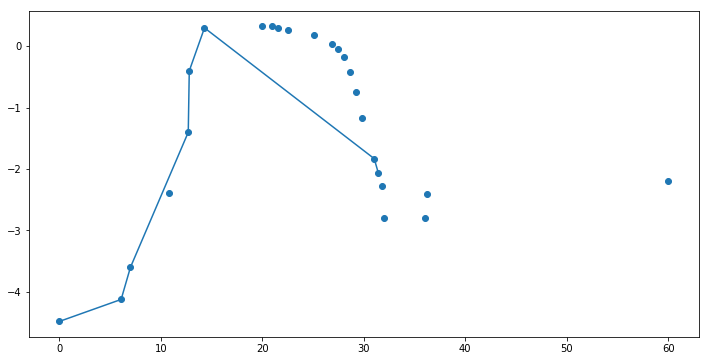

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(x, y)
plt.plot(x[idx], y[idx])

In [12]:
y[idx]

array([-4.481, -4.123, -3.6  , -1.4  , -0.4  ,  0.3  , -1.83 , -2.06 ])

In [13]:
lines = [((x[idx[i]], y[idx[i]]), (x[idx[i + 1]], y[idx[i + 1]]))  for i in range(idx.shape[0] -1)]

In [126]:
best = 0
keep_idx = None

In [133]:
best = 0
for _ in range(1000):

    idx = np.sort(np.random.choice(np.arange(1, x.shape[0] - 1), size=4, replace=False))
    idx = np.insert(idx, 0, 0)
    idx = np.insert(idx, idx.shape[0], x.shape[0] - 1)

    total_inlier = 0

    for line in lines:

        n_inlier = 0
        last_px = 0
        last_py = 0
        for i, (px, py) in enumerate(zip(x, y)):
            
            if distance(line[0], line[1], (px, py)) < 0.4:
#                 w = np.sqrt((px - last_px)**2 + (py - last_py)**2)                
                n_inlier += 1 
                        
            last_py = py
            last_px = px

        total_inlier += n_inlier

        if total_inlier > best:
            keep_idx = idx


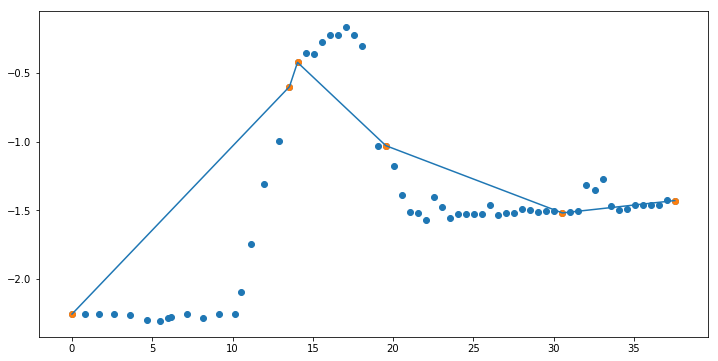

In [134]:
plt.figure(figsize=(12, 6))
plt.scatter(x, y)
plt.plot(x[keep_idx], y[keep_idx])
plt.scatter(x[keep_idx], y[keep_idx])

In [143]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

/opt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.367129e-25
  overwrite_a=True).T


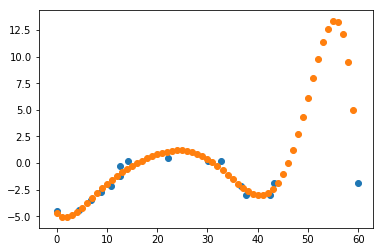

/opt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.343258e-25
  overwrite_a=True).T


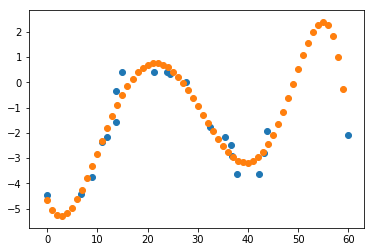

/opt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.342971e-25
  overwrite_a=True).T


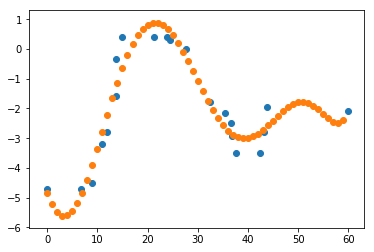

/opt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.193225e-25
  overwrite_a=True).T


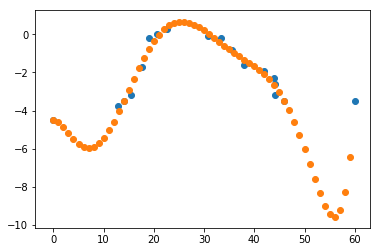

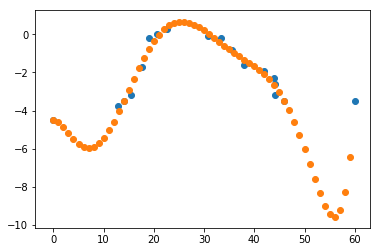

/opt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.320403e-25
  overwrite_a=True).T


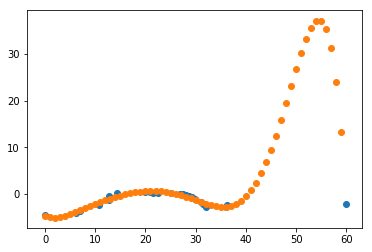

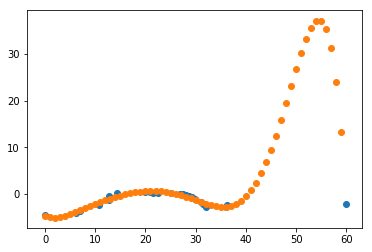

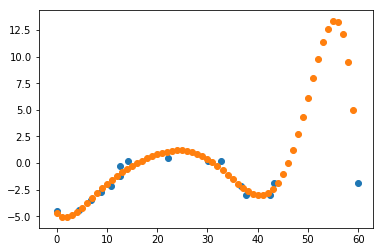

/opt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.103150e-24
  overwrite_a=True).T


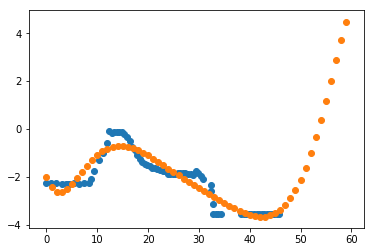

/opt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.184847e-23
  overwrite_a=True).T


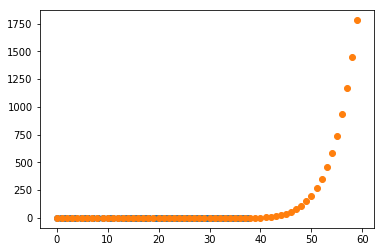

In [173]:
for i in range(10):
    x, y = get_x_y(p, i)

    pm = PolynomialFeatures(7)
    x_ = pm.fit_transform(x[:, None], y)
    m = Ridge()
    m.fit(x_, y)
    
    plt.scatter(x, y)
    
    x_ = pm.transform(np.arange(60)[:, None])
    plt.scatter(np.arange(60), m.predict(x_))
    plt.show()

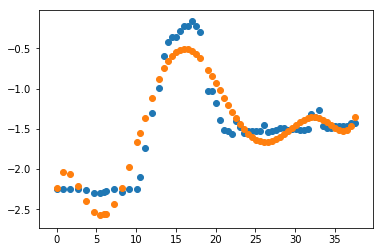

In [24]:
def distance_points(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)     

In [19]:
def interpolate_d(p1, p2, d):
    d0 = distance_points(p1, p2) 
    x = p1[0] + d / d0 * (p2[0] - p1[0])
    y = p1[1] + d / d0 * (p2[1] - p1[1])
    return x, y

In [27]:
lines[0]

((0.0, -4.481), (6.083, -4.123))

In [36]:
best = 0

endline []
[]
endline [0.24771233557850003]
[0.24771233557850003]
endline [2.3032267821545656, 1.7802267821545656, 0.5632267821545656]
[1.5488934488212323]
endline [3.220518595104995, 2.6975185951049947, 1.4805185951049946, 0.4975185951049945]
[1.9740185951049947]
endline [3.934442732665562, 3.411442732665562, 2.194442732665562, 1.211442732665562, 0.21144273266556193]
[2.192642732665562]
endline [2.1626262780116305, 1.6396262780116304, 0.42262627801163033, 0.5603737219883698, 1.5603737219883698, 2.2603737219883695, 2.2903737219883697, 2.2903737219883697, 2.2503737219883697, 2.22037372198837, 2.1503737219883696, 1.9903737219883697, 1.9203737219883696, 1.7903737219883697, 1.5403737219883697, 1.2203737219883697, 0.8003737219883698]
[1.7100065259924744]
endline [2.1626262780116305, 1.6396262780116304, 0.42262627801163033, 0.5603737219883698, 1.5603737219883698, 2.2603737219883695, 2.2903737219883697, 2.2903737219883697, 2.2503737219883697, 2.22037372198837, 2.1503737219883696, 1.9903737219

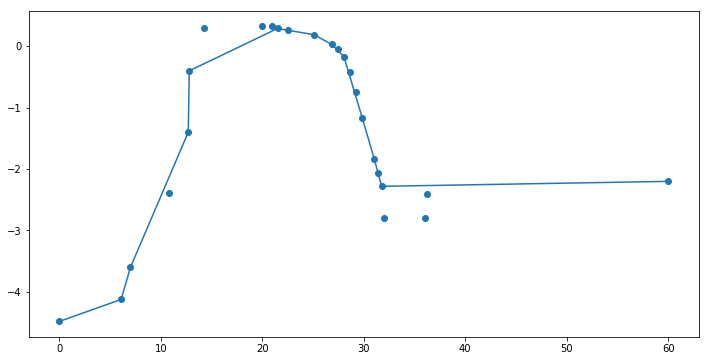

In [46]:
for _ in range(1):

    idx = np.sort(np.random.choice(np.arange(1, x.shape[0] - 1), size=12, replace=False))
    idx = np.insert(idx, 0, 0)
    idx = np.insert(idx, idx.shape[0], x.shape[0] - 1)

    total_inlier = 0

    for line in lines:
        
        d = distance_points(line[0], line[1])
        last_y = line[0][1]
        last_x = line[0][0]
        
        total_error = []
        
        for i in range(int(d // 1)):
            px, py = interpolate_d(line[0], line[1], i + 1)
            avg_y = (last_y + py) / 2
            
            error = []

            for i, (x_point, y_point) in enumerate(zip(x, y)):
                                
                if last_x < x_point < px:
                    error.append(abs(avg_y - y_point))
                    
                last_y = y_point
                last_x = x_point
        
        if len(error) > 0:
            total_error.append(np.mean(error))
        
        print(total_error)
                    
                    

#             if total_inlier > best:
#                 keep_idx = idx


plt.figure(figsize=(12, 6))
plt.scatter(x, y)
plt.plot(x[idx], y[idx])

In [47]:
np.trapz(y, x)

-113.0005355

In [82]:
x, y = get_x_y(p, 9)
best = np.inf

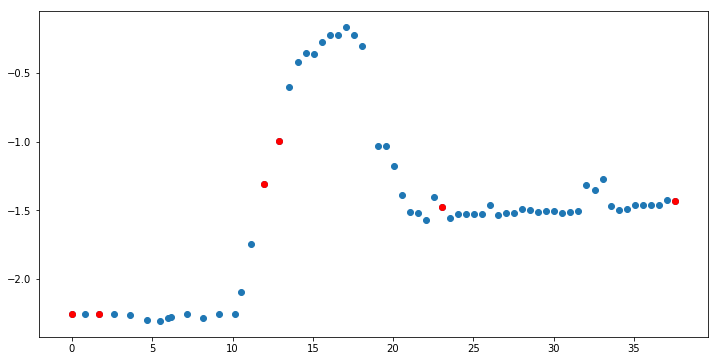

In [109]:
best = np.inf
for _ in range(5000):

    idx = np.sort(np.random.choice(np.arange(1, x.shape[0] - 1), size=4, replace=False))
    idx = np.insert(idx, 0, 0)
    idx = np.insert(idx, idx.shape[0], x.shape[0] - 1)
    
    error = np.abs(np.trapz(y, x) - np.trapz(y[idx], x[idx]))
    
    if error < best:
        best = error
        keep_idx = idx
    

plt.figure(figsize=(12, 6))
plt.scatter(x, y)
plt.scatter(x[keep_idx], y[keep_idx], color='r')

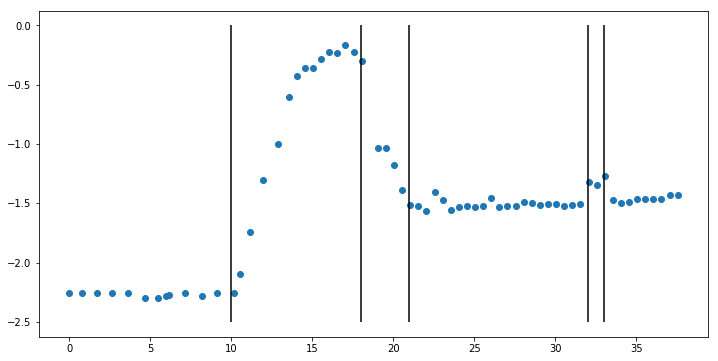

In [103]:
plt.figure(figsize=(12, 6))
plt.scatter(x, y)
plt.vlines(10, -2.5, 0)
plt.vlines(18, -2.5, 0)
plt.vlines(21, -2.5, 0)
plt.vlines(32, -2.5, 0)
plt.vlines(33, -2.5, 0)

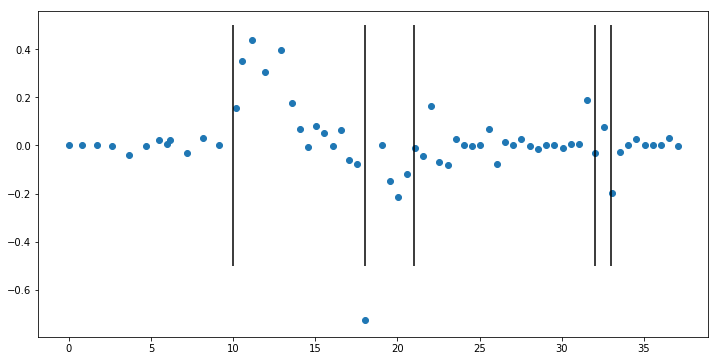

In [105]:
plt.figure(figsize=(12, 6))
plt.scatter(x[:-1], np.diff(y))
plt.vlines(10, -.5, .5)
plt.vlines(18, -.5, .5)
plt.vlines(21, -.5, .5)
plt.vlines(32, -.5, .5)
plt.vlines(33, -.5, .5)

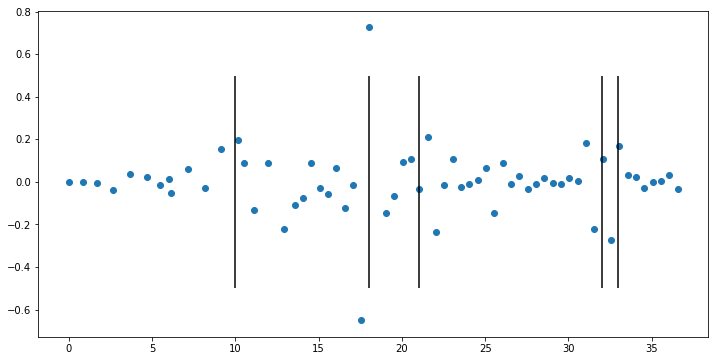

In [106]:
plt.figure(figsize=(12, 6))
plt.scatter(x[:-2], np.diff(y, 2))
plt.vlines(10, -.5, .5)
plt.vlines(18, -.5, .5)
plt.vlines(21, -.5, .5)
plt.vlines(32, -.5, .5)
plt.vlines(33, -.5, .5)